In [1]:
import os
import numpy as np
import pandas as pd
from scipy import stats

import argus_shapes
import pulse2percept.implants as p2pi

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-colorblind')

/home/mbeyeler/anaconda3/lib/python3.5/site-packages/skvideo/__init__.py:356: UserWarning: avconv/avprobe not found in path: 
  warnings.warn("avconv/avprobe not found in path: " + str(path), UserWarning)
2018-04-26 15:18:15,881 [pulse2percept] [INFO] Welcome to pulse2percept


In [2]:
subject_params = {
    'TB': {
        'implant_type': p2pi.ArgusI,
        'implant_x': -1527,
        'implant_y': -556,
        'implant_rot': -1.13,
        'loc_od_x': 13.6,
        'loc_od_y': 0.0,
        'xrange': (-36.9, 36.9),
        'yrange': (-36.9, 36.9)
    },
    '12-005': {
        'implant_type': p2pi.ArgusII,
        'implant_x': -1761,
        'implant_y': -212,
        'implant_rot': -0.188,
        'loc_od_x': 15.4,
        'loc_od_y': 1.86,
        'xrange': (-30, 30),
        'yrange': (-22.5, 22.5)
    },
    '51-009': {
        'implant_type': p2pi.ArgusII,
        'implant_x': -799,
        'implant_y': 93,
        'implant_rot': -1.09,
        'loc_od_x': 15.7,
        'loc_od_y': 0.75,
        'xrange': (-32.5, 32.5),
        'yrange': (-24.4, 24.4)
    },
    '52-001': {
        'implant_type': p2pi.ArgusII,
        'implant_x': -1230,
        'implant_y': 415,
        'implant_rot': -0.457,
        'loc_od_x': 15.9,
        'loc_od_y': 1.96,
        'xrange': (-32, 32),
        'yrange': (-24, 24)
    }
}

use_electrodes = {
    'TB': ['A4', 'C2', 'C3', 'C4', 'D2', 'D3', 'B3', 'D4'],
    '12-005': ['A04', 'A06', 'B03', 'C07', 'C10', 'D07', 'D08', 'D10',
               'F06'],
    '51-009': ['A02', 'C01', 'C05', 'C06', 'D03', 'E01', 'E05', 'E07',
               'F04', 'F06'],
    '52-001': ['A05', 'A07', 'B09', 'A10', 'C10', 'D05', 'D07', 'E04',
               'E09', 'E10', 'F06', 'F07', 'F08', 'F09', 'F10']
}

In [3]:
subjects = ['TB', '12-005', '51-009', '52-001']

In [4]:
datafolder = os.path.join(os.environ['SECOND_SIGHT_DATA'], 'shape')
features = []
targets = []
for subject in subjects:
    f, t = argus_shapes.load_data(datafolder, subject=subject,
                                electrodes=use_electrodes[subject],
                                amplitude=2.0, random_state=42)
    xyrange = np.array([np.diff(subject_params[subject]['xrange'])[0],
                        np.diff(subject_params[subject]['yrange'])[0]])
    t['area'] = [y['area'] / np.prod(x['img_shape']) * np.prod(xyrange)
                 for (_, x), (_, y) in zip(f.iterrows(), t.iterrows())]
    t['orientation'] = np.rad2deg(t['orientation'])
    t['compactness'] = 1.0 / (t['compactness'] / (4 * np.pi))
    t['electrode'] = ['%s%d' % (row['electrode'][0], int(row['electrode'][1:]))
                      for _, row in t.iterrows()]
    argus = subject_params[subject]['implant_type'](x_center=subject_params[subject]['implant_x'],
                                                    y_center=subject_params[subject]['implant_y'],
                                                    rot=subject_params[subject]['implant_rot'])
    t['dist2fovea'] = [np.sqrt(argus[row['electrode']].x_center ** 2 + argus[row['electrode']].y_center ** 2)
                       for _, row in t.iterrows()]
    t['dist2raphe'] = [np.abs(argus[row['electrode']].y_center) for _, row in t.iterrows()]
    t['dist2od'] = [np.sqrt((argus[row['electrode']].x_center - subject_params[subject]['loc_od_x']) ** 2 +
                            (argus[row['electrode']].y_center - subject_params[subject]['loc_od_y']) ** 2)
                    for _, row in t.iterrows()]
    features.append(f)
    targets.append(t)

In [5]:
Xy = pd.concat((pd.concat(features), pd.concat(targets).drop(columns='electrode')), axis=1)

In [6]:
cols = ['area', 'orientation', 'eccentricity', 'compactness']
ylabels = ['area (deg$^2$)', 'orientation (rad)', 'eccentricity', 'compactness']
markers = ['o', 's', 'v', '^']
# colors = ['#0072B2', '#009E73', '#D55E00', '#CC79A7']

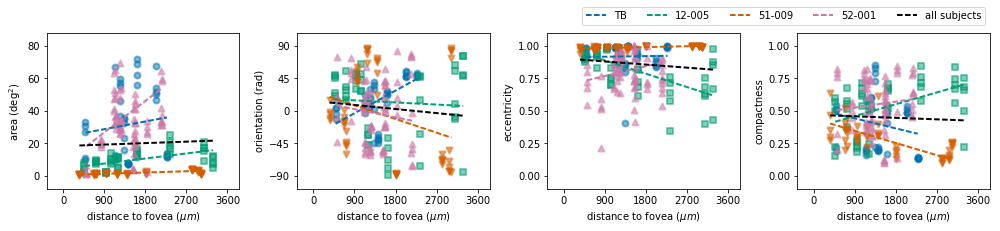

In [15]:
yticks = [[0, 80], [-90, 90], [0, 1], [0, 1]]
ylimits = [[-8, 88], [-108, 108], [-0.1, 1.1], [-0.1, 1.1]]
    
fig, axes = plt.subplots(ncols=len(cols), figsize=(14, 3))
for col, ax, ylabel, ylim, ytick in zip(cols, axes, ylabels, ylimits, yticks):
    d2f = []
    ycol = []
    for (subject, data), marker in zip(gb, markers):
        ax.scatter(data['dist2fovea'], data[col], alpha=0.5, marker=marker,
                   linewidth=2, label=None)
        # Linear fit for subject:
        slope, intercept, rval, pval, _ = stats.linregress(data['dist2fovea'], data[col])
        reg = lambda x: x * slope + intercept
        a = ax.axis()
        ax.plot([np.min(data['dist2fovea']), np.max(data['dist2fovea'])],
                [reg(a[0]), reg(a[1])], '--', linewidth=2, label=subject)
        d2f += list(data['dist2fovea'])
        ycol += list(data[col])
        
    # Linear fit across all subjects:
    d2f = np.array(d2f)
    ycol = np.array(ycol)
    slope, intercept, rval, pval, _ = stats.linregress(d2f, ycol)
    reg = lambda x: x * slope + intercept
    a = ax.axis()
    ax.plot([np.min(d2f), np.max(d2f)], [reg(a[0]), reg(a[1])],
            'k--', linewidth=2, label='all subjects')
    
    ax.set_xlim(-360, 3860)
    ax.set_xticks(np.linspace(0, 3600, 5))
    ax.set_xlabel('distance to fovea ($\mu m$)')
    ax.set_ylim(*ylim)
    ax.set_yticks(np.linspace(*ytick, num=5))
    ax.set_ylabel(ylabel)
    if col == 'compactness':
        ax.legend(loc='upper right', ncol=5, bbox_to_anchor=(1, 1.2))

fig.tight_layout()
fig.savefig('fig5a-fovea.png')

In [10]:
for col in cols:
    print(col)
    d2f = []
    ycol = []
    for subject, data in gb:
        _, _, rval, pval, _ = stats.linregress(data['dist2fovea'], data[col])
        d2f += list(data['dist2fovea'])
        ycol += list(data[col])
        print('%s: r=%.3f, p=%f' % (subject, rval, pval))
    _, _, rval, pval, _ = stats.linregress(d2f, ycol)
    print('All subjects: r=%.2f, p=%f\n' % (rval, pval))

area
TB: r=0.114, p=0.484109
12-005: r=0.523, p=0.000231
51-009: r=0.683, p=0.000000
52-001: r=0.285, p=0.013131
All subjects: r=0.03, p=0.617240

orientation
TB: r=0.559, p=0.000180
12-005: r=-0.060, p=0.697494
51-009: r=-0.260, p=0.067907
52-001: r=-0.064, p=0.587082
All subjects: r=-0.09, p=0.218030

eccentricity
TB: r=0.022, p=0.892881
12-005: r=-0.593, p=0.000018
51-009: r=0.493, p=0.000274
52-001: r=0.119, p=0.309025
All subjects: r=-0.11, p=0.100622

compactness
TB: r=-0.188, p=0.245882
12-005: r=0.450, p=0.001916
51-009: r=-0.662, p=0.000000
52-001: r=0.055, p=0.636609
All subjects: r=-0.04, p=0.567172



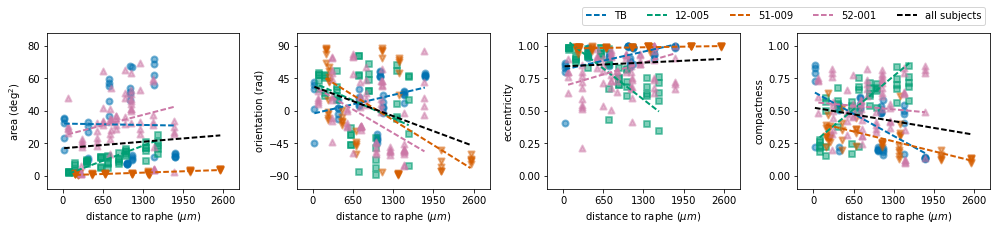

In [16]:
yticks = [[0, 80], [-90, 90], [0, 1], [0, 1]]
ylimits = [[-8, 88], [-108, 108], [-0.1, 1.1], [-0.1, 1.1]]
    
fig, axes = plt.subplots(ncols=len(cols), figsize=(14, 3))
for col, ax, ylabel, ylim, ytick in zip(cols, axes, ylabels, ylimits, yticks):
    d2f = []
    ycol = []
    for (subject, data), marker in zip(gb, markers):
        ax.scatter(data['dist2raphe'], data[col], alpha=0.5, marker=marker,
                   linewidth=2, label=None)
        # Linear fit for subject:
        slope, intercept, rval, pval, _ = stats.linregress(data['dist2raphe'], data[col])
        reg = lambda x: x * slope + intercept
        a = ax.axis()
        ax.plot([np.min(data['dist2raphe']), np.max(data['dist2raphe'])],
                [reg(a[0]), reg(a[1])], '--', linewidth=2, label=subject)
        d2f += list(data['dist2raphe'])
        ycol += list(data[col])
        
    # Linear fit across all subjects:
    d2f = np.array(d2f)
    ycol = np.array(ycol)
    slope, intercept, rval, pval, _ = stats.linregress(d2f, ycol)
    reg = lambda x: x * slope + intercept
    a = ax.axis()
    ax.plot([np.min(d2f), np.max(d2f)], [reg(a[0]), reg(a[1])],
            'k--', linewidth=2, label='all subjects')
    
    ax.set_xlim(-260, 2860)
    ax.set_xticks(np.linspace(0, 2600, 5))
    ax.set_xlabel('distance to raphe ($\mu m$)')
    ax.set_ylim(*ylim)
    ax.set_yticks(np.linspace(*ytick, num=5))
    ax.set_ylabel(ylabel)
    if col == 'compactness':
        ax.legend(loc='upper right', ncol=5, bbox_to_anchor=(1, 1.2))

fig.tight_layout()
fig.savefig('fig5b-raphe.png')

In [12]:
for col in cols:
    print(col)
    d2f = []
    ycol = []
    for subject, data in gb:
        _, _, rval, pval, _ = stats.linregress(data['dist2raphe'], data[col])
        d2f += list(data['dist2raphe'])
        ycol += list(data[col])
        print('%s: r=%.3f, p=%f' % (subject, rval, pval))
    _, _, rval, pval, _ = stats.linregress(d2f, ycol)
    print('All subjects: r=%.2f, p=%f\n' % (rval, pval))

area
TB: r=-0.014, p=0.929354
12-005: r=0.862, p=0.000000
51-009: r=0.821, p=0.000000
52-001: r=0.173, p=0.138842
All subjects: r=0.08, p=0.226168

orientation
TB: r=0.329, p=0.038174
12-005: r=-0.279, p=0.063528
51-009: r=-0.544, p=0.000044
52-001: r=-0.332, p=0.003627
All subjects: r=-0.34, p=0.000000

eccentricity
TB: r=0.513, p=0.000720
12-005: r=-0.762, p=0.000000
51-009: r=0.390, p=0.005170
52-001: r=0.262, p=0.023011
All subjects: r=0.08, p=0.277782

compactness
TB: r=-0.589, p=0.000063
12-005: r=0.701, p=0.000000
51-009: r=-0.619, p=0.000002
52-001: r=-0.062, p=0.599988
All subjects: r=-0.19, p=0.005160



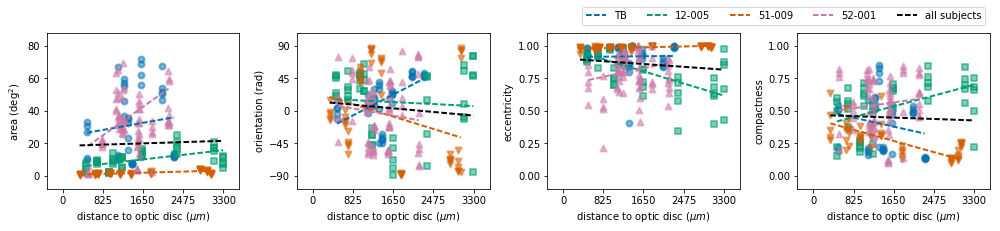

In [17]:
yticks = [[0, 80], [-90, 90], [0, 1], [0, 1]]
ylimits = [[-8, 88], [-108, 108], [-0.1, 1.1], [-0.1, 1.1]]
    
fig, axes = plt.subplots(ncols=len(cols), figsize=(14, 3))
for col, ax, ylabel, ylim, ytick in zip(cols, axes, ylabels, ylimits, yticks):
    d2f = []
    ycol = []
    for (subject, data), marker in zip(gb, markers):
        ax.scatter(data['dist2od'], data[col], alpha=0.5, marker=marker,
                   linewidth=2, label=None)
        # Linear fit for subject:
        slope, intercept, rval, pval, _ = stats.linregress(data['dist2od'], data[col])
        reg = lambda x: x * slope + intercept
        a = ax.axis()
        ax.plot([np.min(data['dist2od']), np.max(data['dist2od'])],
                [reg(a[0]), reg(a[1])], '--', linewidth=2, label=subject)
        d2f += list(data['dist2od'])
        ycol += list(data[col])
        
    # Linear fit across all subjects:
    d2f = np.array(d2f)
    ycol = np.array(ycol)
    slope, intercept, rval, pval, _ = stats.linregress(d2f, ycol)
    reg = lambda x: x * slope + intercept
    a = ax.axis()
    ax.plot([np.min(d2f), np.max(d2f)], [reg(a[0]), reg(a[1])],
            'k--', linewidth=2, label='all subjects')
    
    ax.set_xlim(-330, 3630)
    ax.set_xticks(np.linspace(0, 3300, 5))
    ax.set_xlabel('distance to optic disc ($\mu m$)')
    ax.set_ylim(*ylim)
    ax.set_yticks(np.linspace(*ytick, num=5))
    ax.set_ylabel(ylabel)
    if col == 'compactness':
        ax.legend(loc='upper right', ncol=5, bbox_to_anchor=(1, 1.2))

fig.tight_layout()
fig.savefig('fig5c-od.png')

In [14]:
for col in cols:
    print(col)
    d2f = []
    ycol = []
    for subject, data in gb:
        _, _, rval, pval, _ = stats.linregress(data['dist2od'], data[col])
        d2f += list(data['dist2od'])
        ycol += list(data[col])
        print('%s: r=%.3f, p=%f' % (subject, rval, pval))
    _, _, rval, pval, _ = stats.linregress(d2f, ycol)
    print('All subjects: r=%.2f, p=%f\n' % (rval, pval))

area
TB: r=0.115, p=0.480034
12-005: r=0.520, p=0.000247
51-009: r=0.682, p=0.000000
52-001: r=0.282, p=0.014141
All subjects: r=0.03, p=0.636151

orientation
TB: r=0.559, p=0.000180
12-005: r=-0.061, p=0.690272
51-009: r=-0.258, p=0.071021
52-001: r=-0.060, p=0.606150
All subjects: r=-0.08, p=0.227716

eccentricity
TB: r=0.018, p=0.910282
12-005: r=-0.591, p=0.000019
51-009: r=0.495, p=0.000256
52-001: r=0.113, p=0.335628
All subjects: r=-0.11, p=0.102100

compactness
TB: r=-0.184, p=0.256185
12-005: r=0.447, p=0.002105
51-009: r=-0.663, p=0.000000
52-001: r=0.059, p=0.613657
All subjects: r=-0.04, p=0.561350

